In [3]:
from joblib import Parallel, delayed
from Evolution.EvolutionaryLib import BaseChromosome, ChromosomeClassFactory

import pandas as pd 
from tqdm import tqdm
import random

import torch 
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn 
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                   names=['s_length','s_width','p_length','p_width','y'])
data['y'] = data['y'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
data

,s_length,s_width,p_length,p_width,y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [5]:
class MyDataset(Dataset):
  def __init__(self, df): 
    x=df.iloc[:,0:4].values
    y=df.iloc[:,4].values
 
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.long)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


dataset = MyDataset(data)
train_dataset, test_dataset = random_split(dataset, (120, 30))

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=10) 

In [6]:
class ANN(nn.Module):
    def __init__(self, n:tuple):
        super(ANN, self).__init__()

        architecture = [nn.Linear(4, n[0])]
        for i in range(len(n)-1):
            architecture.append(nn.Linear(n[i], n[i+1]))
            architecture.append(nn.ReLU())

        self.seq = nn.Sequential(
            *architecture
        )
        self.out = nn.Linear(n[-1], 3)

    def forward(self, x):
        x = self.seq(x)
        x = self.out(x)
        return x
criterion = nn.CrossEntropyLoss()

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    iteration = 0
    overall_loss = 0 
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data).softmax(dim=1)

        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        iteration += 1
        overall_loss += loss.item()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # print(f"Test set: Average loss: {test_loss}, Accuracy: {100. * correct / len(test_loader.dataset)} ")
    return 100. * correct / len(test_loader.dataset)

In [8]:
class MyChromosome(BaseChromosome):
    def __init__(self):
        super().__init__()

    def crossover(self, other):
        new = MyChromosome()
        self.copy(new)

        new['network_architecure'] = self._network_architecure.crossover(other._network_architecure)

        new['lr'] = (self['lr'] + other['lr']) / 2

        new['epochs'] = random.choice([self['epochs'], other['epochs']])

        return new

    def mutate(self, rate=0.3):
        new = MyChromosome()
        self.copy(new)

        if random.random() < rate:
            new.lr = new._lr.get()
        else:
            new.lr = self.lr

        if random.random() < rate:
            new.network_architecure = new._network_architecure.mutate()
        else:
            new.network_architecure = self.network_architecure

        if random.random() < rate:
            new.epochs = new._epochs.get()
        else:
            new.epochs = self.epochs
        return new

chromosome_factory = ChromosomeClassFactory(
        network_architecure={'n': list(range(1, 10)), 'range': list(range(3, 60))},
        lr=(1e-7, 1), 
        epochs=list(range(2, 30))
    )

In [9]:
import torch.optim as optim
from math import log

def evaluate(chromosome, show_metric=False): 
    n_iterations = 3
    metric = 0

    for _ in range(n_iterations): 
        model = ANN(chromosome.network_architecure).to(device)
        optimizer = optim.Adam(model.parameters(), lr=chromosome.lr)
        
        for epoch in range(chromosome.epochs):
            train(model, device, train_loader, optimizer, epoch)

        metric += test(model, device, test_loader)
    metric /= n_iterations
    
    if show_metric: 
        print(f'{metric=}')
        
    return metric - (log(log(chromosome.epochs) + sum(chromosome.network_architecure)**0.1))

In [10]:
# evolution hyperparameters initialisation 
POPULATION_SIZE = 30
ITERATIONS = 220
best = None

In [12]:
# need for statistic collection 
statistic_best = []
statistic_mean = []

statistic_n_epochs = []
statistic_lr = []
statistic_n_layers = []
statistic_n_neurons = []

# Evolutionary algorithm 

# initial population initialisation 
population = []
for _ in range(POPULATION_SIZE):
    c = chromosome_factory.generate(MyChromosome)
    population.append(c)

with Parallel(n_jobs=8) as parallel: 
    for _ in tqdm(range(ITERATIONS)):
        scores = parallel(delayed(evaluate)(chromosome) for chromosome in population)
        for i, chromosome in enumerate(population):
            chromosome.set_score(scores[i])
    
    
        # selection of best instances 
        population = sorted(population, key=lambda x: x.get_score(), reverse=True)[:POPULATION_SIZE // 3]
        # checking for the best solution 
        if best is None or population[0].get_score() > best.get_score():
            best = population[0]
    
        # filling the population with new genes 
        while len(population) < POPULATION_SIZE:
            r = random.random()
            if r < 0.33:
                population.append(random.choice(population).crossover(random.choice(population)))
            elif 0.33 <= r < 0.66:
                population.append(random.choice(population).mutate())
            else:
                population.append(chromosome_factory.generate(MyChromosome))

100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [1:01:55<00:00, 16.89s/it]


--Chromosome--
score: 98.6419220292693
network_architecure: (3,)
lr: 0.023963250084511466
epochs: 16
 --Chromosome--
score: 98.56321082668899
network_architecure: (3,)
lr: 0.023963250084511466
epochs: 22
 --Chromosome--
score: 98.55270052711491
network_architecure: (3,)
lr: 0.017346884123074714
epochs: 23
 --Chromosome--
score: 98.55270052711491
network_architecure: (3,)
lr: 0.017346884123074714
epochs: 23



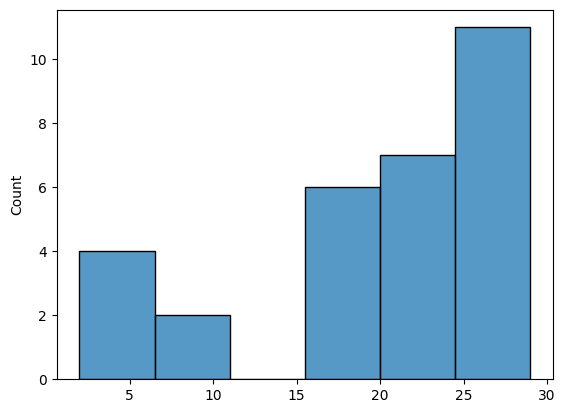

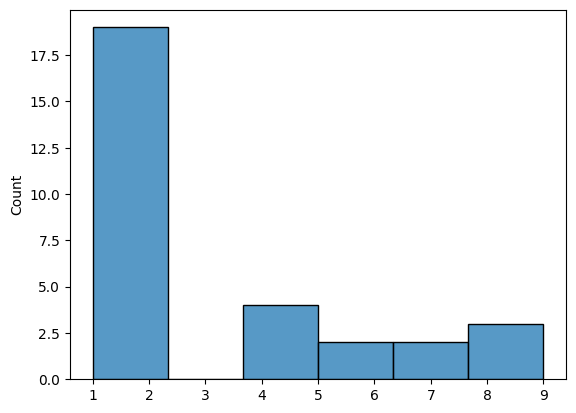

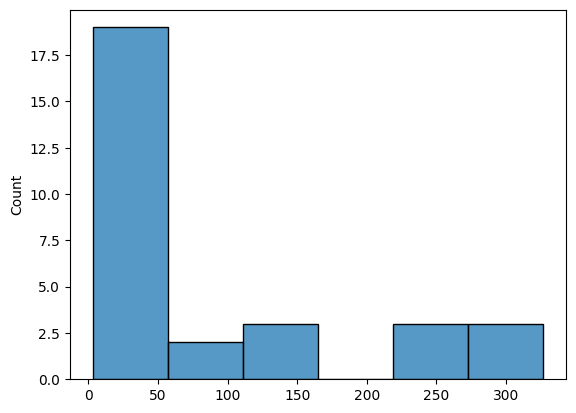

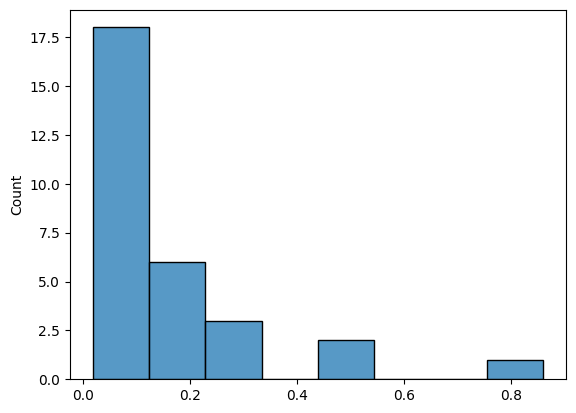

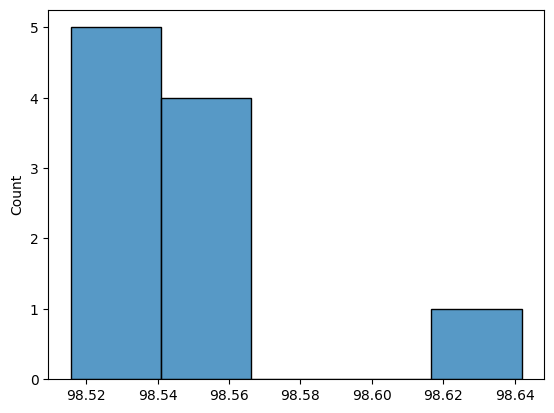

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

print(*population[:4])

sns.histplot(list(map(lambda x: x.epochs, population)))
plt.show()

sns.histplot(list(map(lambda x: len(x.network_architecure), population)))
plt.show()

sns.histplot(list(map(lambda x: sum(x.network_architecure), population)))
plt.show()

sns.histplot(list(map(lambda x: x.lr, population)))
plt.show()

sns.histplot(list(map(lambda x: x.get_score(), population)))
plt.show()